# Artificial Neural Networks and Deep Learning

---

## Homework 1: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 1` in your Google Drive.
2. Upload the `training_set.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 1 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.zip` file to Codabench.


## 🌐 Connect Colab to Google Drive

In [1]:
from google.colab import drive

drive.mount('/gdrive')
#%cd /gdrive/My Drive/Colab Notebooks/AN2DL/Homework 1
%cd /gdrive/My Drive/Homework 1

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1VzWJ3hg8UNcAJNTMZTJ5Vubm00yVjr2s/Homework 1


## ⚙️ Import Libraries

In [2]:
# libraries settings: here I'll add all the necessary libraries during
# the code development

seed = 85 # random variable to make the code reproducible

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import numpy as np
import logging
import random

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import Model, optimizers, losses, initializers, regularizers

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

import hashlib
from sklearn.utils.class_weight import compute_class_weight

2.17.1


## ⏳ Load the Data

In [3]:
data = np.load('training_set.npz') # load the blood cells dataset into a variable called 'data'
print(data.files)

# as we can see in the previus output, the dataset is composed by two arrays: images and labels

['images', 'labels']


In [4]:
# Define a mapping of labels to their corresponding digit names
classes = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'} # 8 classes
# Save unique labels
unique_labels = list(classes.values())

In [5]:
# splitting between images and labels
X = data['images']
y = data['labels']
print(X.shape)
print(y.shape)
# we have 13759 observations that are images of height and weight equal to 96 and 3 channels (RGB images)

(13759, 96, 96, 3)
(13759, 1)


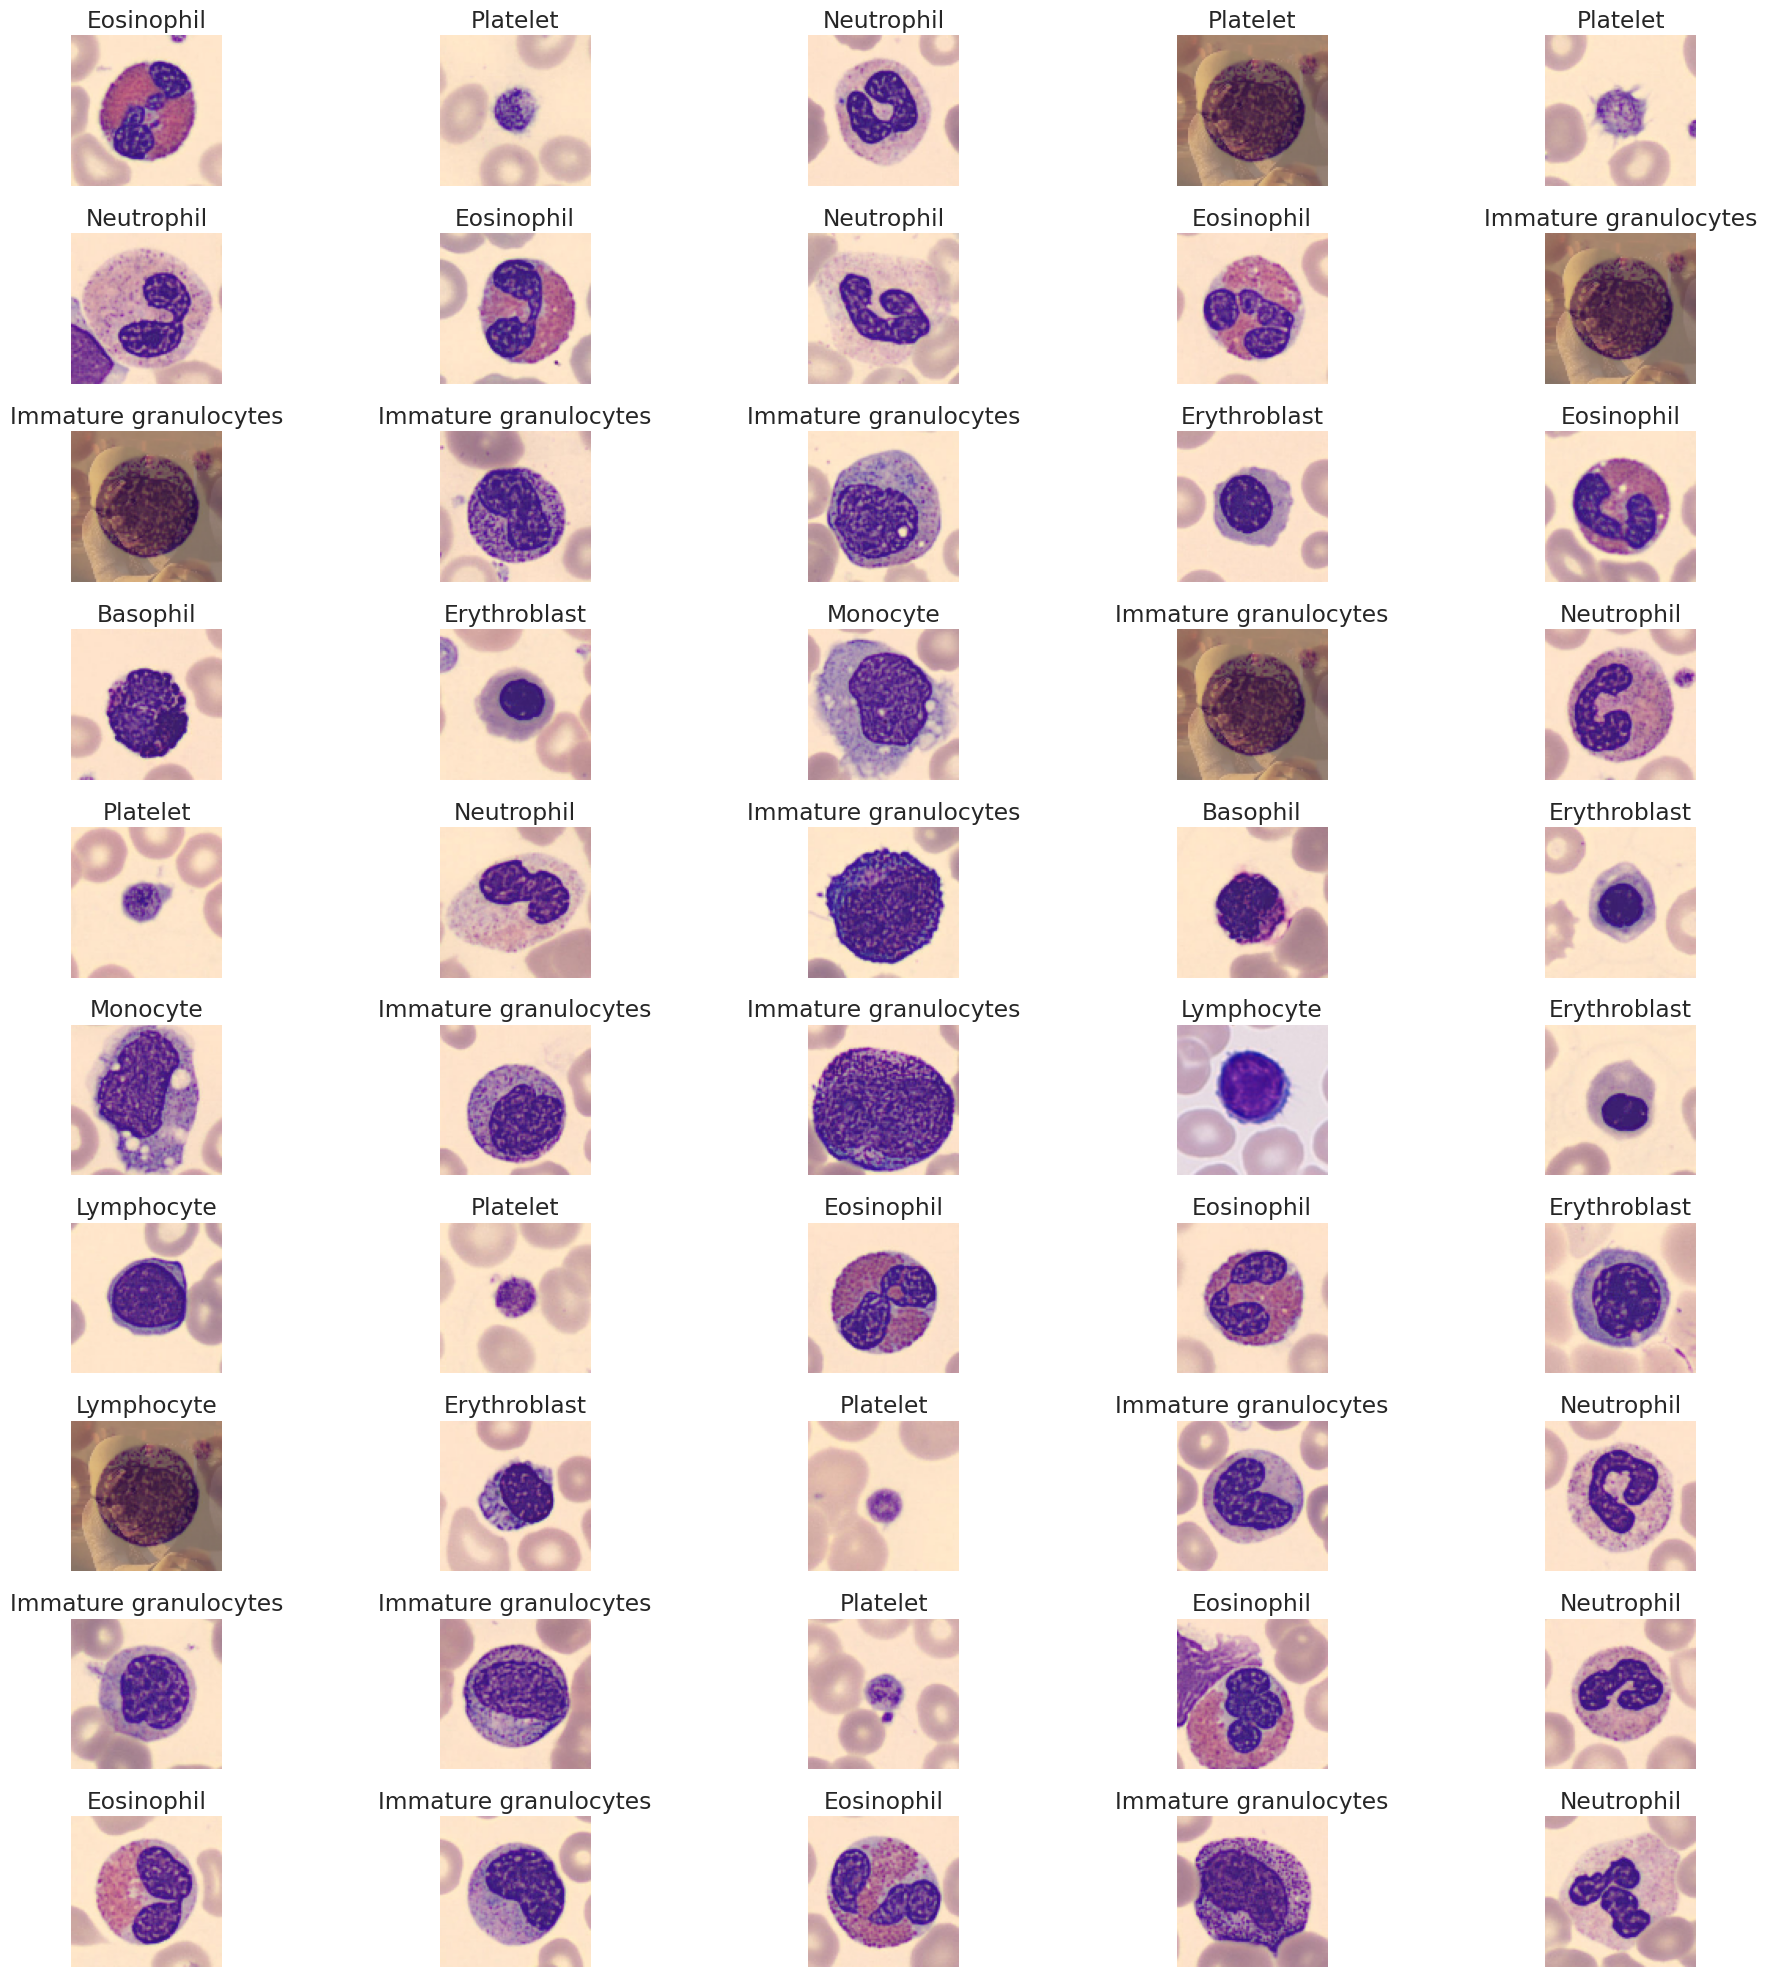

In [6]:
# show a sample of images from the training set

num_img = 50 # 50 random images
random_indices = random.sample(range(len(X)), num_img)

fig, axes = plt.subplots(10, 5, figsize=(20, 20))

# iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i // 5, i % 5]
    ax.imshow(np.squeeze(X[idx]), vmin=0., vmax=1.)
    ax.set_title(f'{classes[y[idx][0]]}')
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

### Investigate dataset

We investigate each labels to find some external images.

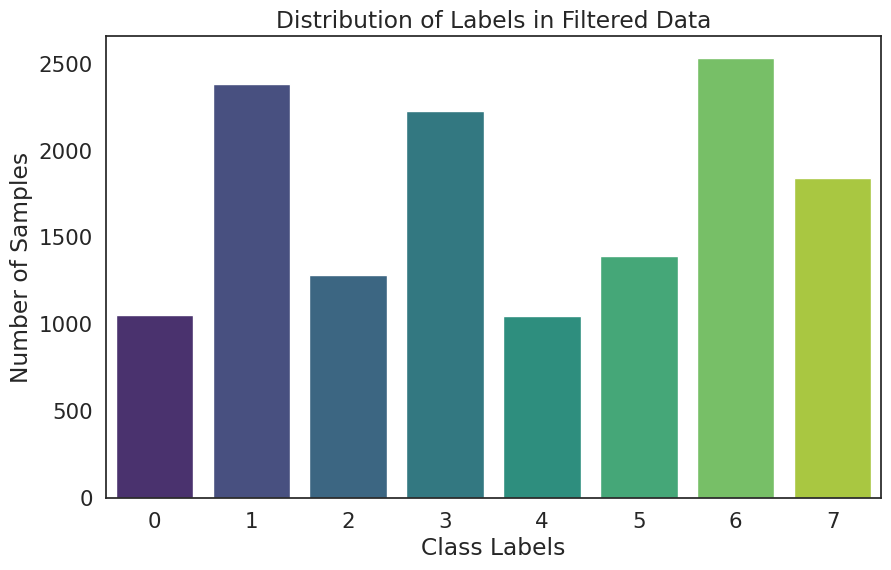

In [7]:
# Count the number of occurrences for each label in y
unique_labels, label_counts = np.unique(y, return_counts=True)

# Plotting the label distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=unique_labels, y=label_counts, palette='viridis')

plt.title('Distribution of Labels in Filtered Data')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.xticks(unique_labels)
plt.show()

In [8]:
# Specify the range of images to consider
n = len(X)

# Filter images with label 5 within the specified range
filtered_images = [X[i] for i in range(n) if y[i] == 5]
filtered_labels = [y[i] for i in range(n) if y[i] == 5]

# Determine the number of images that match the filter
num_filtered = len(filtered_images)
num_filtered

1393

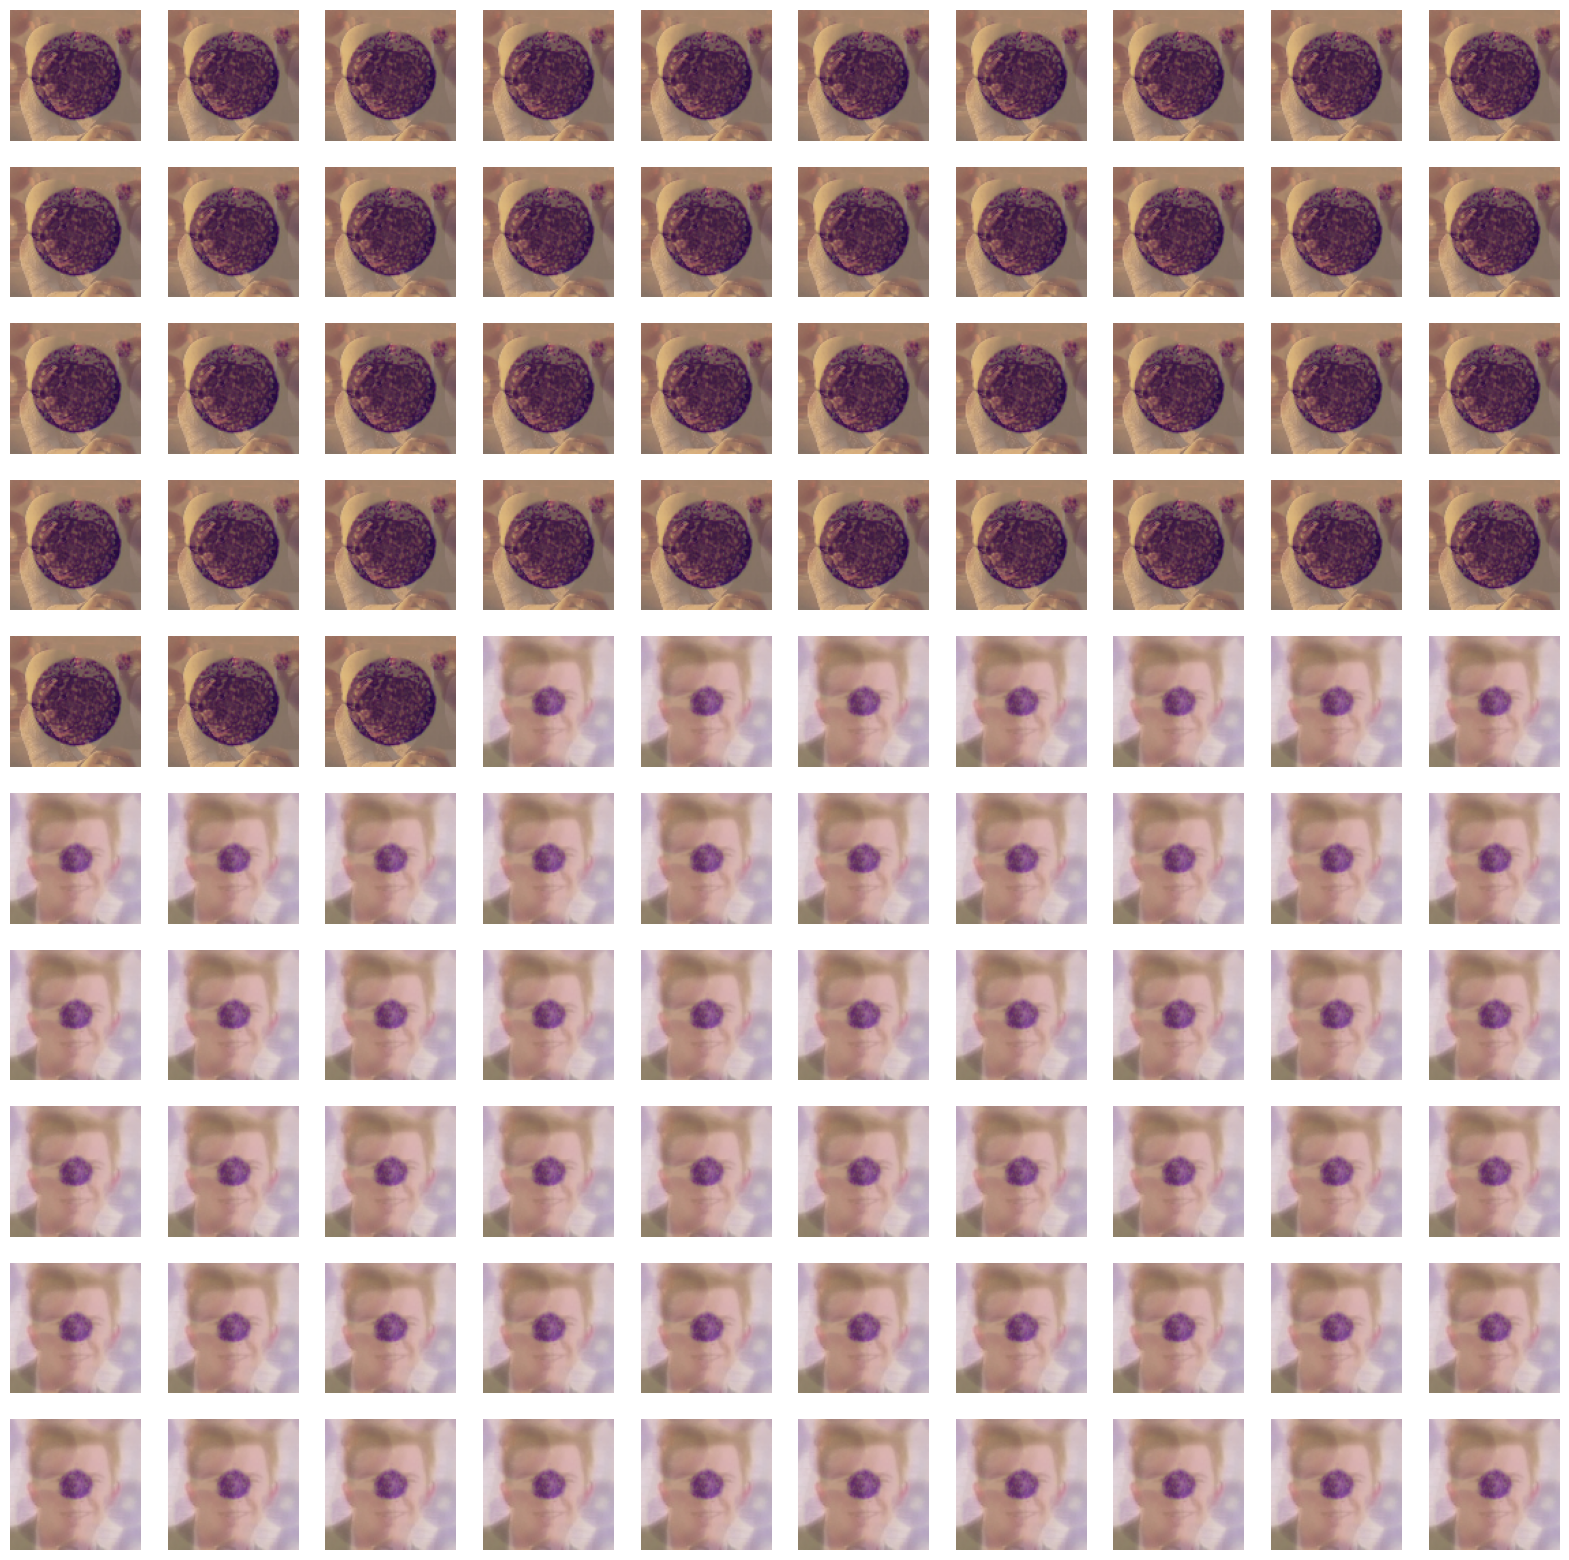

In [9]:
plt.figure(figsize=(20, 20))
for i in range(1150,1250):
    plt.subplot(10, 10, i - 1150 + 1)  # Adjusting the subplot position
    plt.imshow(filtered_images[i], cmap='gray')
    #plt.title(f"Label: {filtered_labels[i]}")
    plt.axis('off')

plt.show()

## Dataset cleaning

We found some external images and we delete all duplicates

In [10]:
# Dictionary to store image hashes and their indices
hash_dict = {}
duplicates = []

for idx, img in enumerate(X):
    # Convert the image to bytes to create a hash
    img_bytes = img.tobytes()
    img_hash = hashlib.md5(img_bytes).hexdigest()

    # Check if the hash exists in hash_dict
    if img_hash in hash_dict:
        # print(f"Duplicate found at index {idx}, duplicate of index {hash_dict[img_hash]}")
        duplicates.append(idx)  # Mark this index as a duplicate
    else:
        hash_dict[img_hash] = idx  # Store unique hash with its index

# Remove duplicates from X and y
X_unique = np.delete(X, duplicates, axis=0)
y_unique = np.delete(y, duplicates, axis=0)

# Save the deduplicated dataset if desired
# np.savez('deduplicated_training_set.npz', images=X_unique, labels=y_unique)

print(f"Removed {len(duplicates)} duplicates. New dataset has {len(X_unique)} images.")

Removed 1806 duplicates. New dataset has 11953 images.


There are also some other images there have be duplicated and in this way we are capable to delete them.
So we check the final distribution of the classes

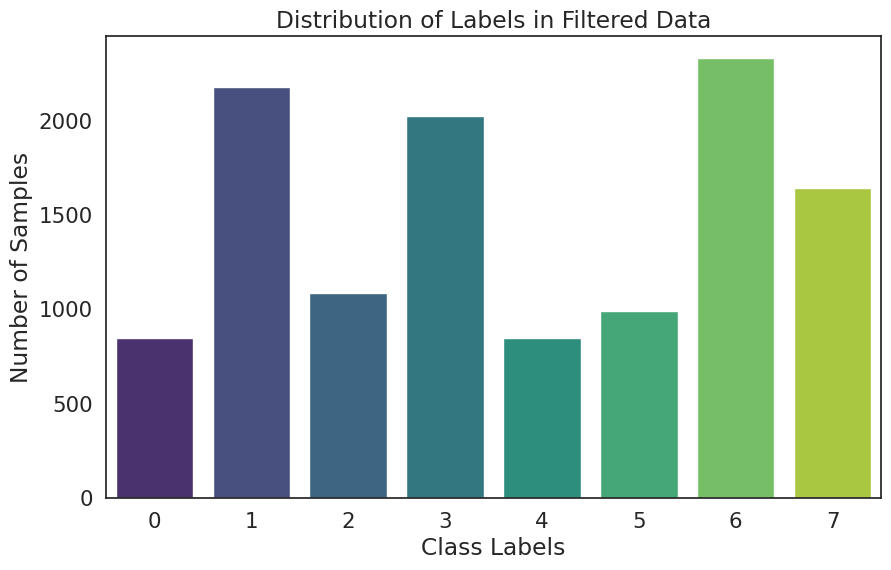

In [11]:
# Count the number of occurrences for each label in y
unique_labels, label_counts = np.unique(y_unique, return_counts=True)

# Plotting the label distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=unique_labels, y=label_counts, palette='viridis')

plt.title('Distribution of Labels in Filtered Data')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.xticks(unique_labels)
plt.show()

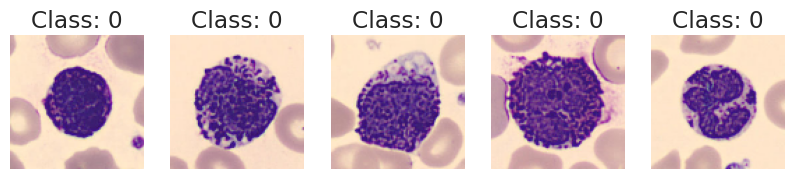

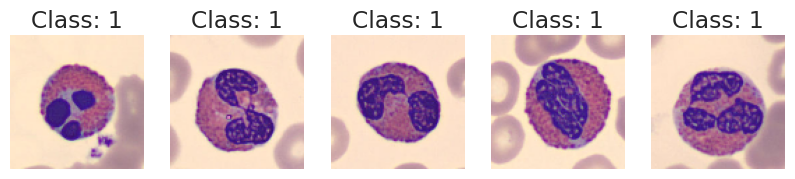

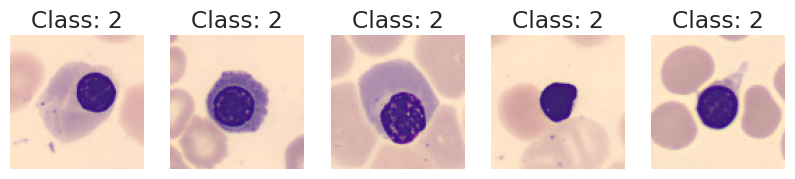

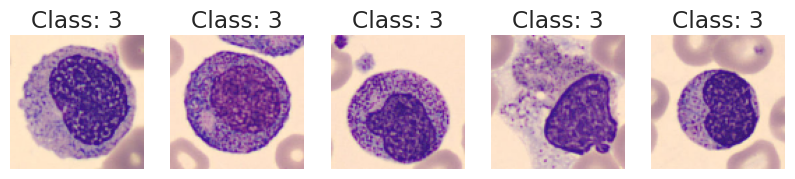

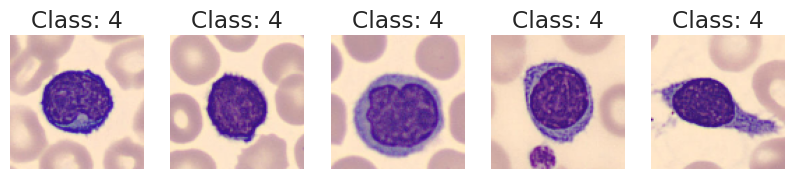

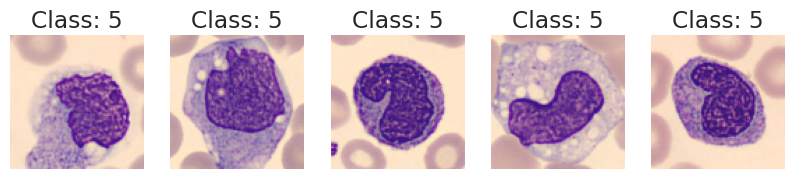

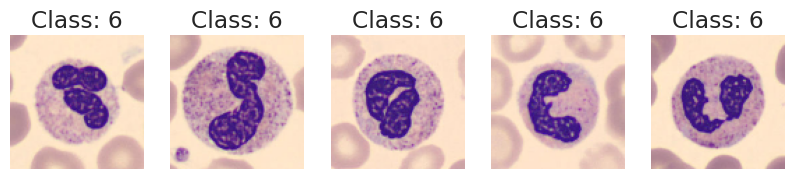

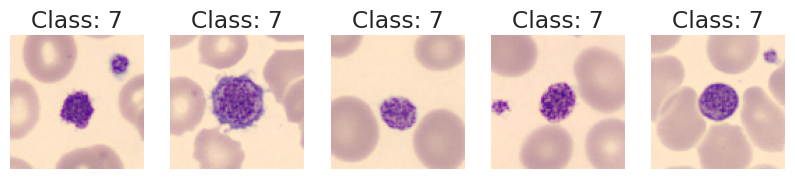

In [12]:
classes = np.unique(y_unique)

# Plot first 5 images for each class
for cls in classes:
    # Find indices where y == cls
    indices = [i for i in range(len(y_unique)) if y_unique[i] == cls][:5]
    images = [X_unique[i] for i in indices]

    # Create a figure for the current class
    plt.figure(figsize=(10, 5))
    for i, img in enumerate(images):
        plt.subplot(1, 5, i + 1)
        plt.imshow(img, cmap='gray')  # Assuming grayscale images; modify if color images
        plt.title(f"Class: {cls}")
        plt.axis('off')
    #plt.suptitle(f"First 5 Images of Class {cls}")
    plt.show()

## Dataset division: train, test

Before divide dataset into train, test and val, we normalize the images

In [13]:
X_unique = X_unique / 255.

In [14]:
# test and validation have the same size
X_train, X_val, y_train, y_val = train_test_split(X_unique, y_unique, test_size=.2, random_state=seed)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)

Train: (9562, 96, 96, 3) (9562, 1)
Validation: (2391, 96, 96, 3) (2391, 1)


As we have to evaluate 8 classes we flatten the y variable to have integer classification classes.

In [15]:
y_train = y_train.flatten()
y_val = y_val.flatten()

Due to data unbalanced we calculate the classes weights

In [16]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.ravel())
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
class_weight_dict

{0: 1.7733679525222552,
 1: 0.683390508862207,
 2: 1.3520927601809956,
 3: 0.750785175879397,
 4: 1.7551395007342143,
 5: 1.488480697384807,
 6: 0.6320729772607087,
 7: 0.9279891304347826}

## Definition of hyperparameters

In [17]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = len(np.unique(y_train))

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


In [18]:
# Number of training epochs
epochs = 200

# Batch size for training
batch_size = 64

# Learning rate: step size for updating the model's weights
learning_rate = 0.0001

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rare:", learning_rate)

Epochs: 200
Batch Size: 64
Learning Rare: 0.0001


In [19]:
# Define regularization
l2_lambda = 1e-3

In [20]:
# Define the patience value for early stopping
patience = 30
# non c'è un motivo per non applicare early stopping

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max', # facciamo il check del massim o e non del minimo
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks_1 = [early_stopping] # che applichiamo poi qui sotto al nostro fit method

In [21]:
# improve callbacks
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode = 'min', patience=patience, restore_best_weights=True)]

## Augumentation

In [22]:
# Choose augumentations
augmentation = tf.keras.Sequential([
    tfkl.RandomZoom(0.2),
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.5,0.5),
    tfkl.RandomRotation(0.3),
    tfkl.RandomBrightness(0.5, value_range=(0,1)),
    # tfkl.RandomContrast(0.7),
], name='preprocessing')

## Model creation

In [23]:
def build_model(input_shape,
                output_shape,
                learning_rate,
                l2_lambda,
                augmentation=None,
                seed=seed):

    # Set the random seed for reproducibility
    tf.random.set_seed(seed)

    # Initialise weights and regulariser
    initializer = initializers.GlorotNormal(seed=seed)
    regularizer = regularizers.l2(l2_lambda)

    # Define the input layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Apply optional data augmentation
    if augmentation is not None:
        x = augmentation(input_layer)
    else:
        x = input_layer

    # Convolutional blocks with initializer and regularizer
    for i, filters in enumerate([32, 64, 128, 256, 512]):
        # Define kernel size based on the number of filters
        if filters == 32 or filters == 64:
            kernel_size = 7
        elif filters == 128:
            kernel_size = 5
        else:
            kernel_size = 3

        x = tfkl.Conv2D(filters=filters, kernel_size=kernel_size, padding='same',
                        kernel_initializer=initializer, name=f'conv{i}')(x)
        x = tfkl.BatchNormalization(name=f'batchNorm{i}')(x)
        x = tfkl.ReLU(name=f'relu{i}')(x)
        x = tfkl.MaxPooling2D(name=f'mp{i}')(x)
        x = tfkl.Dropout(0.25, name=f'dropout{i}')(x)

    # Flatten the output of the convolutional blocks
    x = tfkl.Flatten(name='flatten')(x)

    # Fully connected layers with initializer and regularizer
    for i, units in enumerate([512, 256, 128, 64, 32]):
        x = tfkl.Dense(units=units, activation='relu', kernel_initializer=initializer,
                       kernel_regularizer=regularizer, name=f'fc{i}')(x)


    # Output layer with softmax activation
    output_layer = tfkl.Dense(output_shape, activation='softmax', kernel_initializer=initializer,
                              kernel_regularizer=regularizer, name='output')(x)

    # Define the model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model with Adam optimizer and sparse categorical crossentropy loss function
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss=losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    return model

# Build the model
model = build_model(input_shape, output_shape, learning_rate, l2_lambda, augmentation)

# Display model summary
model.summary(expand_nested=True, show_trainable=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)                  │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ preprocessing (Sequential)          │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_zoom (RandomZoom)       │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_flip (RandomFlip)       │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_translation             │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomTranslation)                 │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_rotation                │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomRotation)                    │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_brightness              │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomBrightness)                  │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv0 (Conv2D)                      │ (None, 96, 96, 32)           │         4,736 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batchNorm0 (BatchNormalization)     │ (None, 96, 96, 32)           │           128 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ relu0 (ReLU)                        │ (None, 96, 96, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp0 (MaxPooling2D)                  │ (None, 48, 48, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout0 (Dropout)                  │ (None, 48, 48, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv1 (Conv2D)                      │ (None, 48, 48, 64)           │       100,416 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batchNorm1 (BatchNormalization)     │ (None, 48, 48, 64)           │           256 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ relu1 (ReLU)                        │ (None, 48, 48, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp1 (MaxPooling2D)                  │ (None, 24, 24, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout1 (Dropout)                  │ (None, 24, 24, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2 (Conv2D)                      │ (None, 24, 24, 128)          │       204,928 │    Y    │
├──────────────────────

 Total params: 4,324,008 (16.49 MB)

 Trainable params: 4,322,024 (16.49 MB)

 Non-trainable params: 1,984 (7.75 KB)

## 🛠️ Train and Save the Model

In [24]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    class_weight=class_weight_dict,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

Epoch 1/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 89ms/step - accuracy: 0.2117 - loss: 3.5515 - val_accuracy: 0.1485 - val_loss: 4.1359
Epoch 2/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.2937 - loss: 3.1059 - val_accuracy: 0.1485 - val_loss: 4.9855
Epoch 3/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.3595 - loss: 2.9130 - val_accuracy: 0.1485 - val_loss: 5.5845
Epoch 4/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - accuracy: 0.4407 - loss: 2.6189 - val_accuracy: 0.3091 - val_loss: 3.5005
Epoch 5/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.5079 - loss: 2.3837 - val_accuracy: 0.4358 - val_loss: 2.3435
Epoch 6/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.5660 - loss: 2.1764 - val_accuracy: 0.6499 - val_loss: 1.8047
Epoch 7/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.5888 - loss: 2.0482 - val_accuracy: 0.4291 - val_loss: 2.4071
Epoch 8/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.6072 - loss: 1

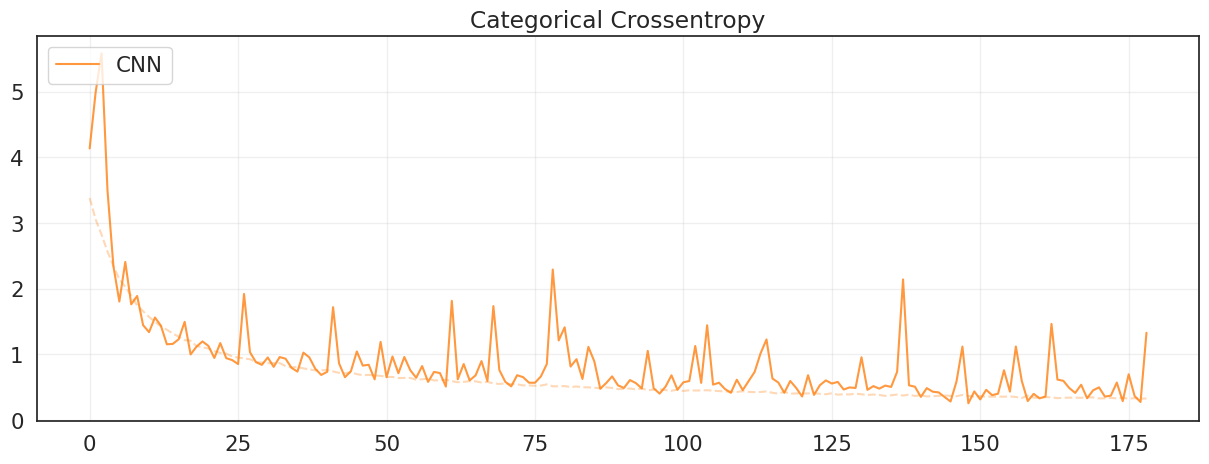

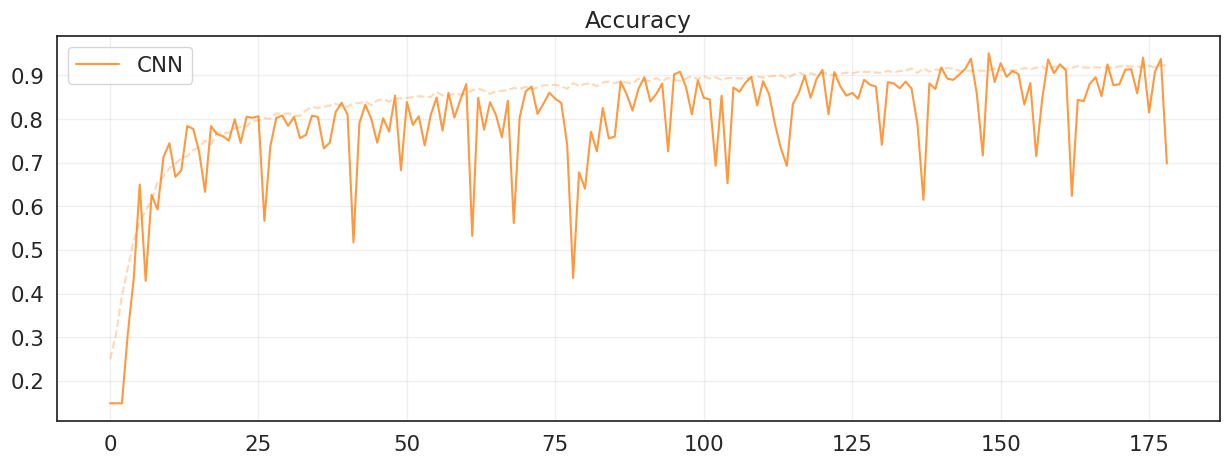

In [25]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

In [26]:
# Predict probabilities for the test set
y_prob = model.predict(X_val)

# Convert probabilities to predicted class labels
y_pred = y_prob.argmax(axis=1)

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [27]:
# Save y_pred as a text file
np.savetxt('y_pred.txt', y_pred, fmt='%d')

print("y_pred saved as 'y_pred.txt'")

y_pred saved as 'y_pred.txt'


In [28]:
model.save('weights.keras')
del model

## Validation set metrics

Accuracy: 0.9506
F1 Score: 0.9505

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.99      0.91       177
           1       1.00      1.00      1.00       430
           2       0.97      0.99      0.98       201
           3       0.97      0.88      0.92       431
           4       0.99      0.73      0.84       168
           5       0.78      0.98      0.87       190
           6       0.97      0.98      0.98       439
           7       1.00      0.99      1.00       355

    accuracy                           0.95      2391
   macro avg       0.94      0.94      0.94      2391
weighted avg       0.96      0.95      0.95      2391



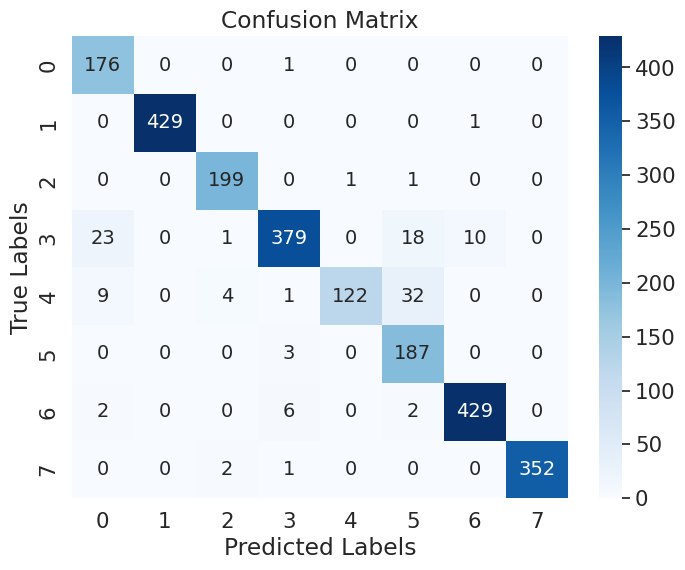

In [29]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='weighted')

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Detailed per-class metrics
print("\nClassification Report:\n", classification_report(y_val, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Display the plot
plt.show()

## 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.

❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [30]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py


In [31]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py weights.keras

from google.colab import files
files.download(filename)

  adding: model.py (deflated 56%)
  adding: weights.keras (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>